In [1]:
!pip install --no-cache-dir -q tensorflow_io

     |████████████████████████████████| 22.7 MB 1.3 MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

import tensorflow as tf
print("Tensorflow Version: {}".format(tf.__version__))

import tensorflow_hub as hub
print("Tensorflow Hub Version: {}".format(hub.__version__))

import tensorflow_io as tfio

Tensorflow Version: 2.7.0
Tensorflow Hub Version: 0.12.0


In the following, we are going to train a environment sound classification model by transfer learning on `YAMNet`. The `YAMNet` is a MobileNetV1 variant model. It takes a length-variant audio wav content in numpy array and returns three ouputs, the score for classification, the embedding for transfer learning, and the log mel spectrum for visualization or debugging. In the end we are going to train a model classifying the audio for cat or dog.

## YAMNet

### From TF.Hub

You can easily load the model from TF.hub.

In [3]:
yamnet_hub_link = 'https://tfhub.dev/google/yamnet/1'
yamnet = hub.load(yamnet_hub_link)

### Example

Assume that the sampling rate of audio is 16kHz, it is a momo and it is sampled in 3 seconds. The audio is also in the range of `[-1.0, +1.0]`.

In [4]:
secs = 3
blank_audio = np.zeros(shape=(secs * 16000), dtype=np.float32)

In [5]:
(example_classes, example_embeddings, example_mel_spectrum) = yamnet(blank_audio)
example_classes.shape, example_embeddings.shape, example_mel_spectrum.shape

(TensorShape([6, 521]), TensorShape([6, 1024]), TensorShape([336, 64]))

The batch size of the outputs of the first two returns is the number of frames (or slices). The frame length is `0.96` second, and the overlap is `0.48` second. (Sample the frame every `0.48` second.). The batch size of the final output is also the number of frames but its length is `0.025` second and the overlap is `0.01` second. The frame is then applied by the `STFT`.

In [6]:
num_frames = np.ceil((secs - 0.96) / 0.48 + 1)
print("The number of frames for the first two returns: {}".format(num_frames))

num_mel_frames = np.ceil((secs - 0.025) / 0.01 + 1)
print("The number of frames for the final returns (for mel spectrum): {}".format(num_mel_frames))

The number of frames for the first two returns: 6.0
The number of frames for the final returns (for mel spectrum): 299.0


In [7]:
frame_length = int(0.025 * 16000)
frame_step = int(0.01 * 16000)
tf.signal.stft(blank_audio, frame_length, frame_step).shape

TensorShape([298, 257])

Notice the dimensions of FFT is different from the one of YAMNet. The detail calculations are described at [github](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/features.py).

### Testing Audio Data

In [8]:
test_wav_file_name = tf.keras.utils.get_file(
  'miaow_16k.wav', 
  'https://storage.googleapis.com/audioset/miaow_16k.wav',
  cache_dir='./',
  cache_subdir='test_data'
)
print(test_wav_file_name)

229376/215546 [===============================] - 0s 0us/step
./test_data/miaow_16k.wav


In [9]:
def load_mono_wav(file_name):
  file_content = tf.io.read_file(filename=file_name)
  _wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
  print("Sample Rate: {} in type {}".format(sample_rate, sample_rate.dtype))
  print("Audio content: {} in type {}".format(_wav.shape, _wav.dtype))

  _wav = tf.squeeze(_wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)  # for resampling
  wav = tfio.audio.resample(_wav, rate_in=sample_rate, rate_out=16000)
  print("Resampled Audio content: {} in type {}".format(wav.shape, wav.dtype))
  return wav

wav = load_mono_wav(test_wav_file_name)

Sample Rate: 16000 in type <dtype: 'int32'>
Audio content: (107698, 1) in type <dtype: 'float32'>
Resampled Audio content: (107698,) in type <dtype: 'float32'>


### About Resampling

In [10]:
signal = np.arange(-10, 10, step=0.005, dtype=np.float32)
signal = np.sin(signal)
signal.shape, signal

((4000,), array([ 0.54402107,  0.5398189 ,  0.5356031 , ..., -0.53176254,
        -0.53598964, -0.54020333], dtype=float32))

In [11]:
resampled = tfio.audio.resample(signal, rate_in=10000, rate_out=5000)
resampled

<tf.Tensor: shape=(2000,), dtype=float32, numpy=
array([-6.3037955e-06,  7.9748006e-06, -1.1850508e-05, ...,
       -2.2375888e-01, -2.3349425e-01, -2.4320629e-01], dtype=float32)>

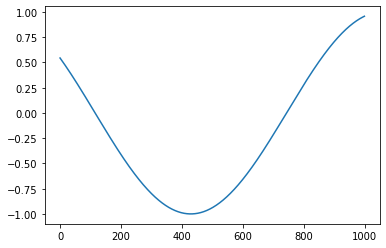

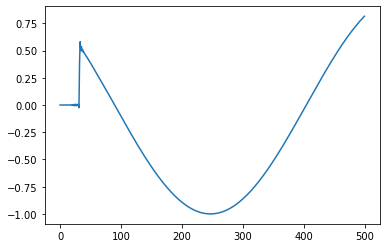

In [12]:
plt.plot(signal[:1000])
plt.show()

plt.plot(resampled[:500])
plt.show()

### Resampling the audio data

Sample Rate: 16000 in type <dtype: 'int32'>
Audio content: (107698, 1) in type <dtype: 'float32'>
Resampled Audio content: (107698,) in type <dtype: 'float32'>


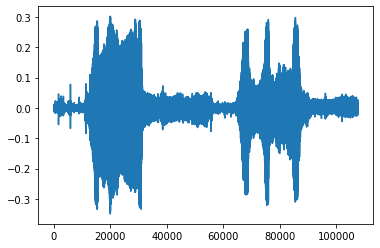

In [13]:
wav = load_mono_wav(test_wav_file_name)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(wav)
plt.show()

In [14]:
display.Audio(wav, rate=16000)

### Load the class mapping

The `class_map_path()` reveals the file of category list. The file is a CSV file and can be read via pandas. The AudioSet dataset provides with 521 audio events.

In [15]:
class_mapping_path = yamnet.class_map_path().numpy().decode('utf-8')
print("The path to class mapping: {}".format(class_mapping_path))

pd.read_csv(class_mapping_path).head(5)

The path to class mapping: /tmp/tfhub_modules/9616fd04ec2360621642ef9455b84f4b668e219e/assets/yamnet_class_map.csv


,index,mid,display_name
0,0,/m/09x0r,Speech
1,1,/m/0ytgt,"Child speech, kid speaking"
2,2,/m/01h8n0,Conversation
3,3,/m/02qldy,"Narration, monologue"
4,4,/m/0261r1,Babbling


In [16]:
class_names = list(pd.read_csv(class_mapping_path)['display_name'])
print("First 5 class names: {}".format(class_names[:5]))
print("There are {} classes in total.".format(len(class_names)))

First 5 class names: ['Speech', 'Child speech, kid speaking', 'Conversation', 'Narration, monologue', 'Babbling']
There are 521 classes in total.


### Run the inference

YAMNet provides frame-based class-scores, that is 521 scores for each frame. In order to determine clip-level predictions, you can simply aggregate per-class scores across frames by using `mean` or `max`, etc.

In [17]:
scores, embeddings, spectrum = yamnet(wav)
num_ts, num_cls = scores.numpy().shape
scores.shape, embeddings.shape, spectrum.shape

(TensorShape([13, 521]), TensorShape([13, 1024]), TensorShape([672, 64]))

In [18]:
avg_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(avg_scores).numpy()
print("The class is {} (index: {}).".format(class_names[top_class], top_class))

The class is Animal (index: 67).


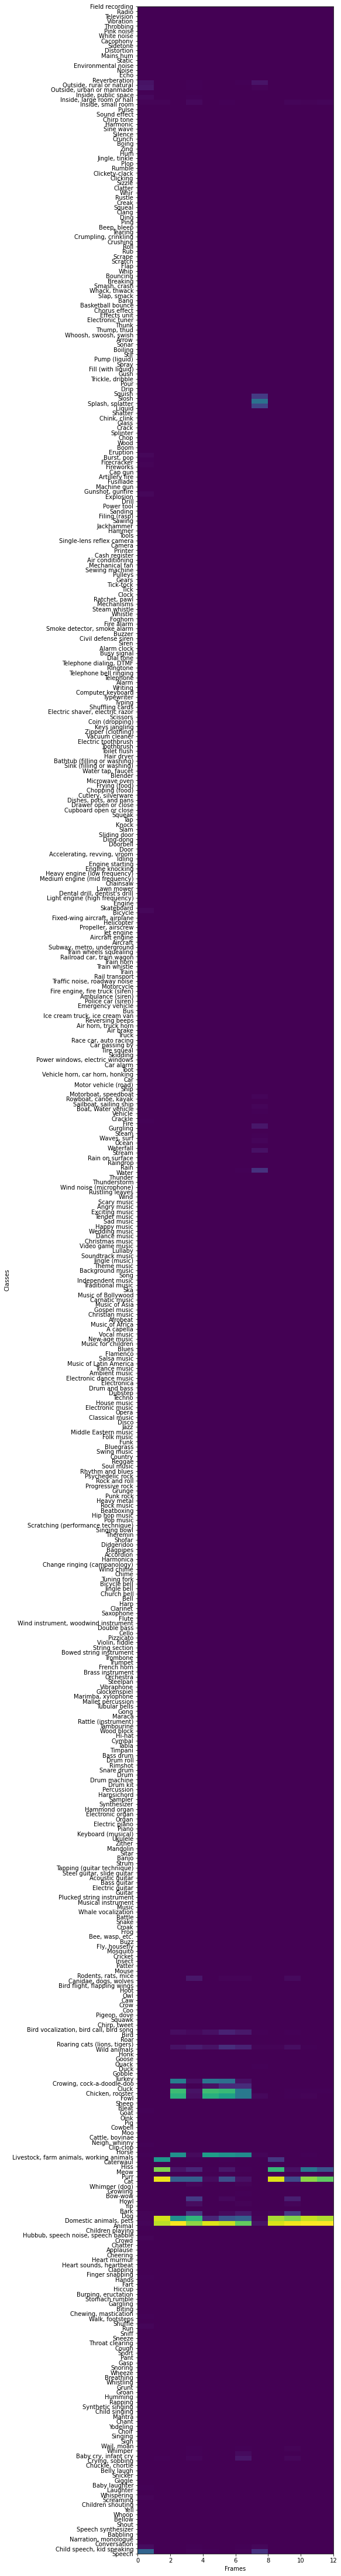

In [19]:
y_ticks = list(range(num_cls))

fig, ax = plt.subplots(1, 1, figsize=(6, 80))
ax.pcolormesh(list(range(num_ts)), 
              y_ticks,
              scores.numpy().T)
ax.set_xlabel("Frames")

ax.set_ylabel("Classes")
ax.set_yticks(y_ticks)
ax.set_yticklabels(class_names)
plt.show()

## ESC-50 dataset

The [ESC-50](https://github.com/karoldvl/ESC-50/archive/master.zip) dataset is a collection of 2000 five-second long environment audio recordings. The dataset contains 50 categories with 40 examples per class.

In [20]:
dataset_link = "https://github.com/karoldvl/ESC-50/archive/master.zip"

status = tf.keras.utils.get_file(
  fname="esc50.zip",
  origin=dataset_link,
  cache_dir='./',
  cache_subdir='esc50',
  extract=True
)
print(status)

645693440/Unknown - 46s 0us/step./esc50/esc50.zip


After downloading and extracting the zip file, you would find the labeling at `meta` and the audio data at `audio`.

In [21]:
meta_path = './esc50/ESC-50-master/meta/esc50.csv'
audio_path = './esc50/ESC-50-master/audio'
assert os.path.exists(meta_path) and os.path.exists(audio_path)

num_audio_files = next(os.walk(audio_path))[2]
print("There are {} audio files in total.".format(len(num_audio_files)))

There are 2000 audio files in total.


### Explore the data

In [22]:
audio_data_frame = pd.read_csv(meta_path)
audio_data_frame.head(10)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
5,1-101296-B-19.wav,1,19,thunderstorm,False,101296,B
6,1-101336-A-30.wav,1,30,door_wood_knock,False,101336,A
7,1-101404-A-34.wav,1,34,can_opening,False,101404,A
8,1-103298-A-9.wav,1,9,crow,False,103298,A
9,1-103995-A-30.wav,1,30,door_wood_knock,False,103995,A


In [23]:
audio_data_frame["fold"].unique()

array([1, 2, 3, 4, 5])

### Filter the data

Now we can filter the data frame by picking up the rows whose tags are dog or cat. After filtering the data frame, we will apply some transformations.

1. Apply the new class ID to dog with 0, and to cat with 1.
2. Concatenate the audio path with the full path.

In [71]:
category_id_mapping = {'dog': 0, 'cat': 1}
id_category_mapping = {0: 'dog', 1: 'cat'}
category_list = list(category_id_mapping.keys())

filtered_data_frame = audio_data_frame[audio_data_frame["category"].isin(category_list)]
filtered_data_frame.head(5)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
157,1-30226-A-0.wav,1,0,dog,True,30226,A
158,1-30344-A-0.wav,1,0,dog,True,30344,A
170,1-32318-A-0.wav,1,0,dog,True,32318,A


In [25]:
filtered_data_frame["category"] = filtered_data_frame["category"].apply(
  lambda element: category_id_mapping[element]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [98]:
filtered_data_frame['filename'] = filtered_data_frame['filename'].apply(
  lambda path: os.path.join(audio_path, path)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [99]:
filtered_data_frame.head(5)

,filename,fold,target,category,esc10,src_file,take
0,./esc50/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
14,./esc50/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A
157,./esc50/ESC-50-master/audio/1-30226-A-0.wav,1,0,dog,True,30226,A
158,./esc50/ESC-50-master/audio/1-30344-A-0.wav,1,0,dog,True,30344,A
170,./esc50/ESC-50-master/audio/1-32318-A-0.wav,1,0,dog,True,32318,A


In [100]:
filtered_data_frame.iloc[4]

filename    ./esc50/ESC-50-master/audio/1-32318-A-0.wav
fold                                                  1
target                                                0
category                                            dog
esc10                                              True
src_file                                          32318
take                                                  A
Name: 170, dtype: object

In [29]:
display.Audio("./esc50/ESC-50-master/audio/1-100032-A-0.wav", rate=16000)

### Loading audio files and retrieve the embeddings

Next we will prepare a function for loading the audio file and pass it to the function of retrieving the embedding. The embedding's shape is `[N, 1024]` and `N` is the number of split frames. 

Second, we also load the `category` and the `fold` column from the data frame. The `category` is the labelings for training, validating, and testing. The other `fold` is the tag for spliting the sub-dataset. The audio is different from the image or the text. In most cases, the audio would be split into several parts, which are often overlapped. Using the tradition way of spliting the dataset might cause the validating or the test less effective.

Third we will prepare the datasets in pipeline for further training.

In [30]:
audio_file_paths = filtered_data_frame["filename"]
audio_category = filtered_data_frame["category"]
audio_fold = filtered_data_frame["fold"]

def load_mono_wav_16K(path, category, fold):
  """for pipelining"""
  wav = load_mono_wav(path)
  return wav, category, fold

main_ds = tf.data.Dataset.from_tensor_slices((audio_file_paths, audio_category, audio_fold))
main_ds = main_ds.map(load_mono_wav_16K)
main_ds.element_spec

Sample Rate: Tensor("DecodeWav:1", shape=(), dtype=int32) in type <dtype: 'int32'>
Audio content: (None, 1) in type <dtype: 'float32'>


Resampled Audio content: <unknown> in type <dtype: 'float32'>


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [41]:
def yamnet_embedding(wav, category, fold):
  """prepared to batching dataset"""
  scores, embeddings, spectrum = yamnet(wav)
  num_frames = tf.shape(embeddings)[0]
  return embeddings, \
         tf.repeat(category, (num_frames), axis=0), \
         tf.repeat(fold, (num_frames), axis=0)

# here we apply unbatch for doing batch dataset in the next step
batch_main_ds = main_ds.map(yamnet_embedding).unbatch()
batch_main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Spliting the data

Next, we will split the data into training, validating, and testing sub-datasets by using the `fold` tag. ESC50 is arranged into 5 uniformly-sized cross validation folds. It makes sure that same clips from the same origin would be in the same tag.

In [48]:
cache_ds = batch_main_ds.cache()
training_ds = cache_ds.filter(lambda embedding, category, fold: fold < 4)
validating_ds = cache_ds.filter(lambda embedding, category, fold: fold == 4)
testing_ds = cache_ds.filter(lambda embedding, category, fold: fold == 5)

# remove the fold tag
filter_fold_tag = lambda embedding, category, fold: (embedding, category)

training_ds = training_ds.map(filter_fold_tag)
validating_ds = validating_ds.map(filter_fold_tag)
testing_ds = testing_ds.map(filter_fold_tag)

batch_size = 64
training_ds = training_ds.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validating_ds = validating_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
testing_ds = testing_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [49]:
for _ds_wav, _ds_category in training_ds.take(1):
  print(_ds_wav.shape, _ds_category.shape)

(64, 1024) (64,)


## Building a model

Next, we are going to build a model, train it, and evaluate it.

In [80]:
audio_model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embeddings'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=len(category_list))
], name='audio_model')

audio_model.summary()

Model: "audio_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 512)               524800    
                                                                 
 dense_33 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


## Training and Evaluating the model

In [81]:
callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   patience=3, 
                                   restore_best_weights=True)
]

audio_model.compile(optimizer='adam', 
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                    metrics=['accuracy'])

audio_model.fit(training_ds, 
                epochs=20, 
                validation_data=validating_ds, 
                callbacks=callbacks)

Epoch 1/20
8/8 [==============================] - 1s 63ms/step - loss: 1.2606 - accuracy: 0.8000 - val_loss: 1.9045 - val_accuracy: 0.8687
Epoch 2/20
8/8 [==============================] - 0s 35ms/step - loss: 0.7877 - accuracy: 0.8750 - val_loss: 0.4164 - val_accuracy: 0.9062
Epoch 3/20
8/8 [==============================] - 0s 37ms/step - loss: 0.4159 - accuracy: 0.8896 - val_loss: 0.2192 - val_accuracy: 0.9187
Epoch 4/20
8/8 [==============================] - 0s 35ms/step - loss: 0.2795 - accuracy: 0.8979 - val_loss: 0.1930 - val_accuracy: 0.9187
Epoch 5/20
8/8 [==============================] - 0s 36ms/step - loss: 0.2130 - accuracy: 0.9083 - val_loss: 0.2214 - val_accuracy: 0.9187
Epoch 6/20
8/8 [==============================] - 0s 35ms/step - loss: 0.2313 - accuracy: 0.9146 - val_loss: 0.2339 - val_accuracy: 0.9187
Epoch 7/20
8/8 [==============================] - 0s 37ms/step - loss: 0.2362 - accuracy: 0.9125 - val_loss: 0.2057 - val_accuracy: 0.9187


In [82]:
testing_loss, testing_acc = audio_model.evaluate(testing_ds)
print("Testing loss: {:.4f}, accuracy: {:.2%}".format(testing_loss, testing_acc))

3/3 [==============================] - 0s 20ms/step - loss: 0.2406 - accuracy: 0.9000
Testing loss: 0.2406, accuracy: 90.00%


### Testing the data

In [83]:
wav = load_mono_wav(test_wav_file_name)
scores, embeddings, spectrum = yamnet(wav)

audio_class = audio_model(embeddings, training=False).numpy()
class_id = audio_class.mean(axis=0).argmax()
print(f"Inference class ID: {id_category_mapping[class_id]}")

Sample Rate: 16000 in type <dtype: 'int32'>
Audio content: (107698, 1) in type <dtype: 'float32'>
Resampled Audio content: (107698,) in type <dtype: 'float32'>
Inference class ID: cat


## Exporting the model

In the following section, we package all the above, accept the audio wav as the model input and the class ID as the model output. In the first step, we should wrap the output processing as a layer.

In [84]:
class Reduce_Mean(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kargs):
    super(Reduce_Mean, self).__init__(**kargs)
    self.axis = axis

  def call(self, x):
    return tf.reduce_mean(x, axis=self.axis)

Now we can package the model. To keep the output node easier to trace every time after building the model. We can assign the node name.

In [87]:
def build_audio_model():
  inputs = tf.keras.layers.Input(shape=(), 
                                 dtype=tf.float32,
                                 name='input_wav')
  _, embeddings, _ = hub.KerasLayer(yamnet_hub_link, 
                                    trainable=False)(inputs)
  class_probs = audio_model(embeddings)
  class_probs_mean = Reduce_Mean(axis=0, name="classifier")(class_probs)
  return tf.keras.Model(inputs=inputs, outputs=class_probs_mean)

wrapped_model = build_audio_model()
wrapped_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_wav (InputLayer)      [(None,)]                 0         
                                                                 
 keras_layer_5 (KerasLayer)  [(None, 521),             0         
                              (None, 1024),                      
                              (None, 64)]                        
                                                                 
 audio_model (Sequential)    (None, 2)                 525826    
                                                                 
 classifier (Reduce_Mean)    (2,)                      0         
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


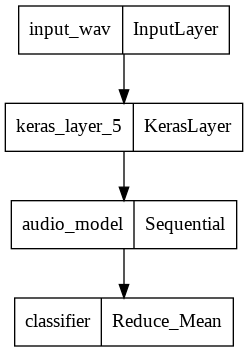

In [88]:
tf.keras.utils.plot_model(wrapped_model)

In [89]:
wrapped_model.save("./audio_model", include_optimizer=False)

INFO:tensorflow:Assets written to: ./audio_model/assets


INFO:tensorflow:Assets written to: ./audio_model/assets


### Reloading the model

In [93]:
wav = load_mono_wav(test_wav_file_name)

reload_model = tf.keras.models.load_model("./audio_model")
results = reload_model(wav, training=False).numpy()
print("The main sound: {}".format(id_category_mapping[np.argmax(results)]))

Sample Rate: 16000 in type <dtype: 'int32'>
Audio content: (107698, 1) in type <dtype: 'float32'>
Resampled Audio content: (107698,) in type <dtype: 'float32'>


The main sound: cat


## From scratch

### Classification Results

filename    ./esc50/ESC-50-master/audio/5-169983-A-5.wav
fold                                                   5
target                                                 5
category                                             cat
esc10                                              False
src_file                                          169983
take                                                   A
Name: 1641, dtype: object
Sample Rate: 44100 in type <dtype: 'int32'>
Audio content: (220500, 1) in type <dtype: 'float32'>
Resampled Audio content: (80000,) in type <dtype: 'float32'>


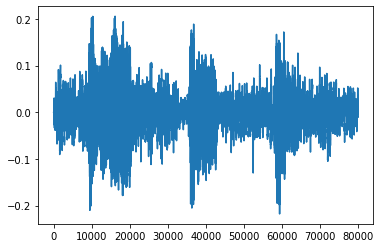

In [108]:
val_ds = filtered_data_frame[filtered_data_frame["fold"] == 5]
print(val_ds.iloc[0])

val_fname = val_ds.iloc[0]["filename"]
val_wav = load_mono_wav(val_fname)

plt.plot(val_wav)
plt.show()

display.Audio(val_wav, rate=16000)

In [109]:
val_wav = load_mono_wav(val_fname)
reload_model = tf.keras.models.load_model("./audio_model")
results = reload_model(val_wav, training=False).numpy()
print("The main sound: {}".format(id_category_mapping[np.argmax(results)]))

Sample Rate: 44100 in type <dtype: 'int32'>
Audio content: (220500, 1) in type <dtype: 'float32'>
Resampled Audio content: (80000,) in type <dtype: 'float32'>


The main sound: cat


### Probability Results

In [116]:
socres, _, _ = yamnet(val_wav)
mean_score = tf.reduce_mean(scores, axis=0)
class_id = tf.argmax(mean_score).numpy()
class_name = class_names[class_id]
class_prob = mean_score[class_id]
print("[YAMNET] Class name: {}, Prob: {:.4f}".format(class_name, class_prob))

results = reload_model(val_wav, training=False).numpy()
probs = tf.nn.softmax(results, axis=0)
prob_id = tf.argmax(probs).numpy()
print("[TRANSFER LEARNING] Class name: {}, Probs: {:.4f}".format(
  id_category_mapping[prob_id], probs[prob_id]))

[YAMNET] Class name: Animal, Prob: 0.7093
[TRANSFER LEARNING] Class name: cat, Probs: 0.9637
